<h1 align="center"> Statistics and Financial Data Science </h1>




GARCH examples
===

In [1]:
%reset -f

In [2]:
#import pandas_datareader as pd_data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
import math as m
import scipy as sp
from statsmodels.stats.anova import anova_lm
import pandas_datareader as pd_data

In [3]:
# Importing the Time Series Analysis module for simulating data
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMAResults
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa.stattools as sm_tools

In [4]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import pmdarima as pm 
from datetime import datetime
# For splines
import patsy
from patsy import dmatrix
from arch import arch_model
from arch.univariate import ARX
from arch.univariate import GARCH
import pandas_datareader.data as web
import datetime as dt
import scipy.stats as st

In [5]:
# Will fix figure size for this notebook
plt.rcParams["figure.figsize"] = (8,6)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [14]:

def plot_diagnosticsTight3(data):

    fig, ((ax1,ax2),(ax3,ax4), (ax5,ax6)) = plt.subplots(3,2,figsize=(10,10))
    
    ax1.hist(data, bins =40,color='m', density = True)  
    mu = data.mean()
    sigma = data.std()
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 2419)
    ax1.plot(x, stats.norm.pdf(x, mu, sigma), linewidth= 5)
    ax1.grid()
    ax1.set_title("Hist Data")
    
    ax2.plot(data)
    ax2.grid()
    ax2.set_title("Data")
    
    fig = plot_acf(data,lags=40,zero=False, ax = ax3,use_vlines = True)
    ax3.grid()
    
    #logData = np.floor(np.log(len(data)))
    ljbox_test = sm.stats.acorr_ljungbox(data,10)#package version
    
    ax4.plot(ljbox_test[1])
    ax4.axhline(y=0.05, color='r',ls='--')
    ax4.set_title("LB test")
    ax4.grid()
    
    fig = sm.qqplot(data, line='q', ax = ax5)
    ax5.grid()
    
    ax6.plot(data*data)
    ax6.grid()
    ax6.set_title("Data Sqr")
    
    plt.tight_layout()

In [7]:
start = dt.datetime(2007,1,1)
end = dt.datetime(2019,11,26)
AAPL = web.get_data_yahoo('AAPL', start=start, end=end)
AAPL.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-11-20,66.519997,65.099998,66.385002,65.797501,106234400.0,64.704376
2019-11-21,66.002502,65.294998,65.922501,65.502502,121395200.0,64.414268
2019-11-22,65.794998,65.209999,65.647499,65.445000,65325200.0,64.357727
2019-11-25,66.610001,65.629997,65.677498,66.592499,84020400.0,65.486168
2019-11-26,66.790001,65.625000,66.735001,66.072502,105207600.0,64.974815


In [8]:
# Let's look at the returns
AAPLRet = np.log(AAPL['Adj Close']).diff().dropna()
AAPLRet.head()

Date
2007-01-04    0.021953
2007-01-05   -0.007147
2007-01-08    0.004926
2007-01-09    0.079800
2007-01-10    0.046746
Name: Adj Close, dtype: float64

1) Plot ACF/PACF for first impression on autoregressive features

2) Test for stationarity (otherwise transform)

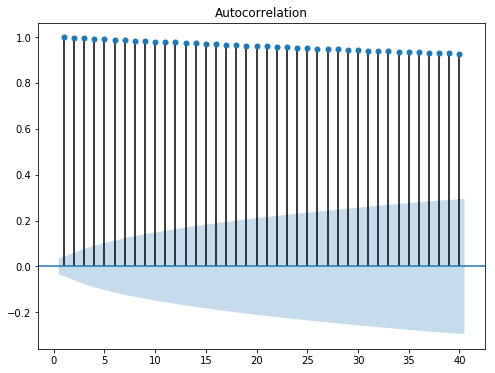

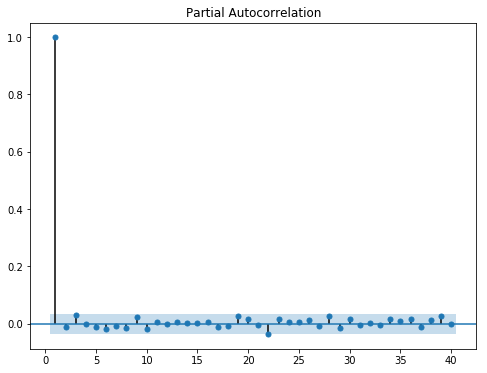

In [11]:
plot_acf(AAPL['Adj Close'],zero = False, lags = 40);
plot_pacf(AAPL['Adj Close'], zero = False, lags =40);
plt.show()

Data passes the stationarity tests - I can consider modelling as an ARMA process
===

In [13]:
# Reject Unit Root
test = adfuller(AAPLRet, maxlag = 5)
print('ADF Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:i/')
for item, value in test[4].items():
    print('\t%s: %.2f' % (item, value))

ADF Statistic: -27.638172
p-value: 0.000000
Critical Values:i/
	1%: -3.43
	5%: -2.86
	10%: -2.57


In [10]:
# Kpss test supports stationarity
num = len(AAPLRet)
maxLag = np.log(num)
test = kpss(AAPLRet, lags = int(maxLag)) 
print('KPSS Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:')
for item, value in test[3].items():
    print('\t%s: %.2f' % (item, value))

KPSS Statistic: 0.059144
p-value: 0.100000
Critical Values:
	10%: 0.35
	5%: 0.46
	2.5%: 0.57
	1%: 0.74


3) Find / fit best ARMA model (already differenced once).

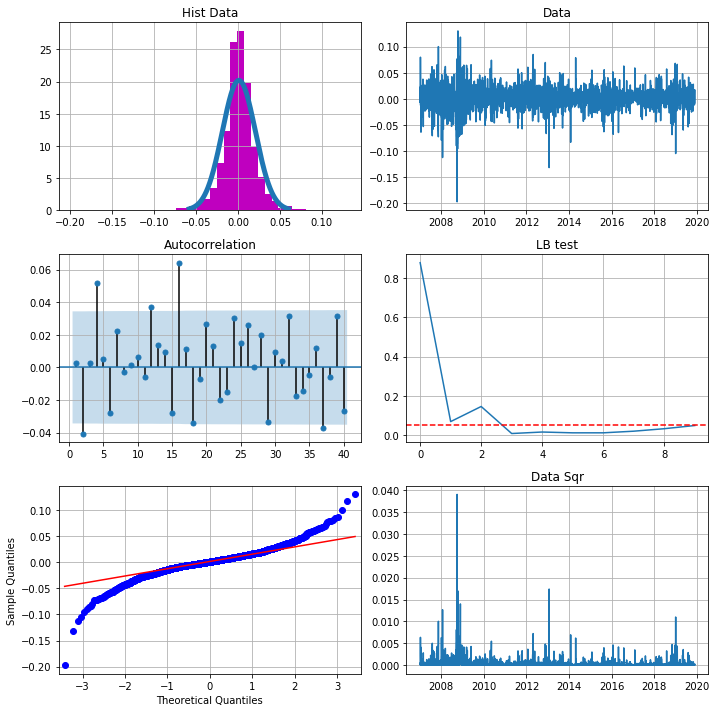

In [16]:
# Just plotting graphs on the actual data and examining the results fo the Ljung-Box test...
# I see that there is auto-correlation

plot_diagnosticsTight3(AAPLRet)

In [17]:
# Define a very simple function to searhch for models - will have to be flexible, given that
# Python arch_model does not take as mean the ARMA model, but only ARX model...
# When possible, will choose simpler models.

def searchARMA(data, exog, max_p, max_q):
 
    aic = np.zeros((max_p,max_q))
    for i in range(max_p):
        for j in range(max_q):
            try:
                if(len(exog) == len(data)):
                    model = ARMA(data,(i,j), exog = exog) 
                else:
                     model = ARMA(data,(i,j)) 
                res = model.fit(trend='nc')
                aic[i,j] = res.aic
                print('p:',i,' q:', j,' aic:', aic[i,j])
            except:
                continue

In [18]:
# So can fit an ARMA type model
results = pm.auto_arima(AAPLRet, trace = True, seasonal=False, with_intercept=True, start_q=0, max_p = 6, max_q = 6,d=0) #d = 1
# Order selected is given in summary
print(results.summary())
# This chooses AR 4 model for the mean

Fit ARIMA: order=(2, 0, 0); AIC=-16274.785, BIC=-16250.442, Fit time=0.101 seconds
Fit ARIMA: order=(0, 0, 0); AIC=-16273.410, BIC=-16261.238, Fit time=0.006 seconds
Fit ARIMA: order=(1, 0, 0); AIC=-16271.433, BIC=-16253.176, Fit time=0.030 seconds
Fit ARIMA: order=(0, 0, 1); AIC=-16271.435, BIC=-16253.178, Fit time=0.023 seconds
Fit ARIMA: order=(3, 0, 0); AIC=-16272.807, BIC=-16242.378, Fit time=0.092 seconds
Fit ARIMA: order=(2, 0, 1); AIC=-16272.791, BIC=-16242.362, Fit time=0.265 seconds
Fit ARIMA: order=(3, 0, 1); AIC=-16274.819, BIC=-16238.304, Fit time=1.351 seconds
Fit ARIMA: order=(4, 0, 1); AIC=-16277.016, BIC=-16234.415, Fit time=0.702 seconds
Fit ARIMA: order=(4, 0, 0); AIC=-16278.970, BIC=-16242.455, Fit time=0.224 seconds
Fit ARIMA: order=(5, 0, 1); AIC=-16276.551, BIC=-16227.865, Fit time=1.281 seconds
Fit ARIMA: order=(5, 0, 0); AIC=-16277.058, BIC=-16234.457, Fit time=0.279 seconds
Total fit time: 4.355 seconds
                              ARMA Model Results         

In [19]:
# Unsurprisingly, same here

exog = np.arange(1)
searchARMA(AAPLRet, exog, max_p=6, max_q = 1)

p: 1  q: 0  aic: -16265.252451486536
p: 2  q: 0  aic: -16267.940325912845
p: 3  q: 0  aic: -16266.032533226193
p: 4  q: 0  aic: -16273.02920104569
p: 5  q: 0  aic: -16271.214001529373


3b) Just repeating results in SARIMAX to get functions from this class


In [20]:
model = sm.tsa.SARIMAX(AAPLRet, order=(4, 0, 0), trend='c')
fit = model.fit()
print(fit.summary());

                           Statespace Model Results                           
Dep. Variable:              Adj Close   No. Observations:                 3248
Model:               SARIMAX(4, 0, 0)   Log Likelihood                8145.485
Date:                Thu, 26 Nov 2020   AIC                         -16278.970
Time:                        11:46:01   BIC                         -16242.455
Sample:                             0   HQIC                        -16265.888
                               - 3248                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0010      0.000      2.733      0.006       0.000       0.002
ar.L1          0.0027      0.011      0.249      0.804      -0.019       0.024
ar.L2         -0.0385      0.012     -3.139      0.0

We notice a few points about this model"
- Coeff phi_1 and phi_3 seem not to be statistically signficant. 
- In fact, all coefficients are very small .... 
- This can also be observed as per the order of the ACF in the plots.
- For the moment, will work with this model, but we are aware that perhaps, a constant mean model 
- combined with perhaps a GARCH model might be suitable.

4) Plot Diagnostics on residuals of the model

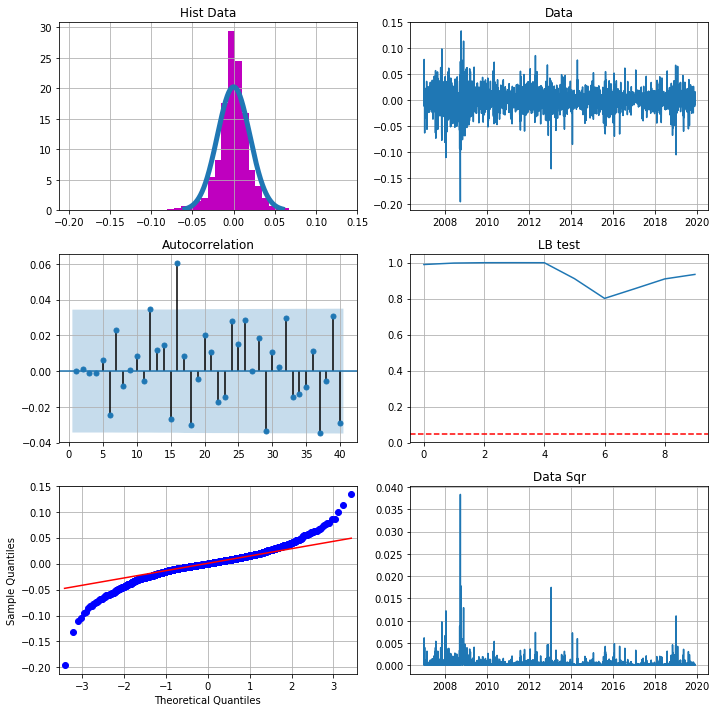

In [21]:
plot_diagnosticsTight3(fit.resid)

Even though there is no auto-correlation and residuals pass the Ljung-Box test, there seem to be clusters 
in the data and also the QQ plot does not fit with normality. There could be due to heteroskedasticity - so we examine
the squared residulas

5) Check squared residuals ACF/PACF - these indicate some AR with order maybe 5 - 9, depending on how complex we wish model to be.

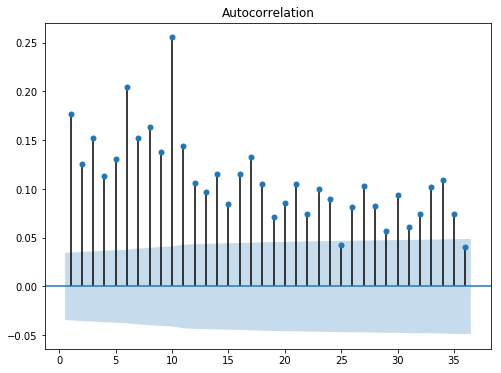

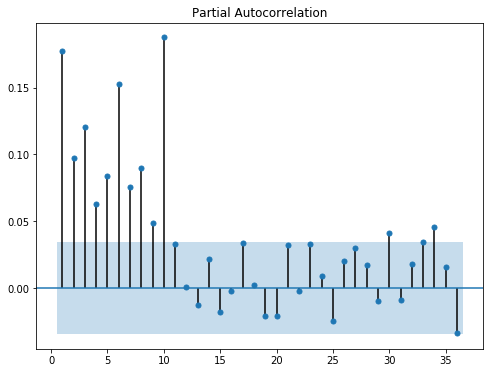

In [22]:
plot_acf(fit.resid**2, zero = False);
plot_pacf(fit.resid**2, zero = False);
plt.show()

In [62]:
# Above were examples with SARIMAX which are familiar with. In arch_model we need to
# specify a mean model using a different method - this is restricted to AR type only, with 
# potential external regressors.

6) Combine the models by specifying the mean and vol processes into a GARCH model:

In [23]:
# The model allows us to choose specific lags - this is very similar to the SARIMAX function from statsmodels:
# Diff are possibly due to numerical approx / methods/ tolerance

newAAPLRet = AAPLRet
arx = ARX(newAAPLRet, lags=4,rescale = False) #this is eq. to AR(4) as per above
arx.volatility = GARCH(5,0,0)
res = arx.fit(update_freq=0)#, tol=0.000001
print(res.summary())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8320.790433430995
            Iterations: 3
            Function evaluations: 66
            Gradient evaluations: 3
                           AR - ARCH Model Results                            
Dep. Variable:              Adj Close   R-squared:                       0.004
Mean Model:                        AR   Adj. R-squared:                  0.002
Vol Model:                       ARCH   Log-Likelihood:                8320.79
Distribution:                  Normal   AIC:                          -16619.6
Method:            Maximum Likelihood   BIC:                          -16552.7
                                        No. Observations:                 3244
Date:                Thu, Nov 26 2020   Df Residuals:                     3233
Time:                        11:46:44   Df Model:                           11
                                   Mean Model                                  


- I'm suspiscious on the convergence of the model as all alphas are the same. 
- We can try using the rescale function to see if we obtain an improvement or
- We can try to scale the returns (by x 100)... let's try both and watch the effect on coefficients

In [31]:
newAAPLRet =AAPLRet*100
arx = ARX(newAAPLRet, lags=4,rescale = False) #this is eq. to AR(4) as per above
arx.volatility = GARCH(5,0,0)
res = arx.fit(update_freq=0)#, tol=0.000001
print(res.summary())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6470.784675298437
            Iterations: 23
            Function evaluations: 330
            Gradient evaluations: 23
                           AR - ARCH Model Results                            
Dep. Variable:              Adj Close   R-squared:                      -0.003
Mean Model:                        AR   Adj. R-squared:                 -0.004
Vol Model:                       ARCH   Log-Likelihood:               -6470.78
Distribution:                  Normal   AIC:                           12963.6
Method:            Maximum Likelihood   BIC:                           13030.5
                                        No. Observations:                 3244
Date:                Thu, Nov 26 2020   Df Residuals:                     3233
Time:                        11:48:13   Df Model:                           11
                                   Mean Model                                 

7) Analyse outputs and consider diagnostics of model

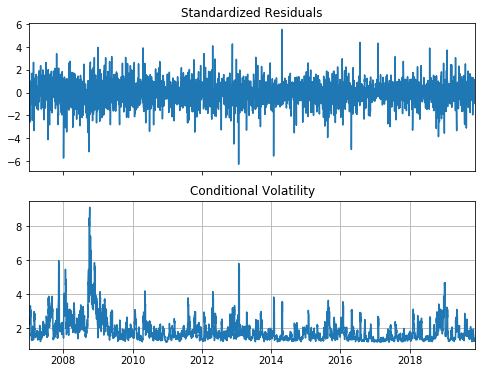

In [32]:
# Exploring the outputs
res.plot()
plt.grid()
plt.show()

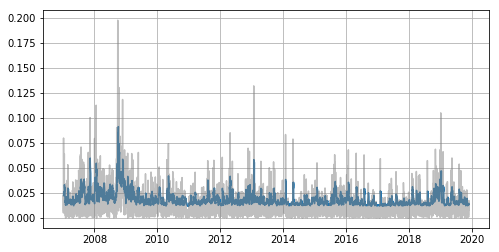

In [33]:
# Plot conditional vol vs abs(ret)
plt.figure(1, figsize=(8,4))
plt.plot(res.conditional_volatility/100)
plt.plot(abs(AAPLRet), color = 'grey', alpha = 0.5)
plt.grid()
plt.show()

7) Consider Diagnostics of StdResiduals: Ljung-Box tests to verify no autocorrelation and normality tests

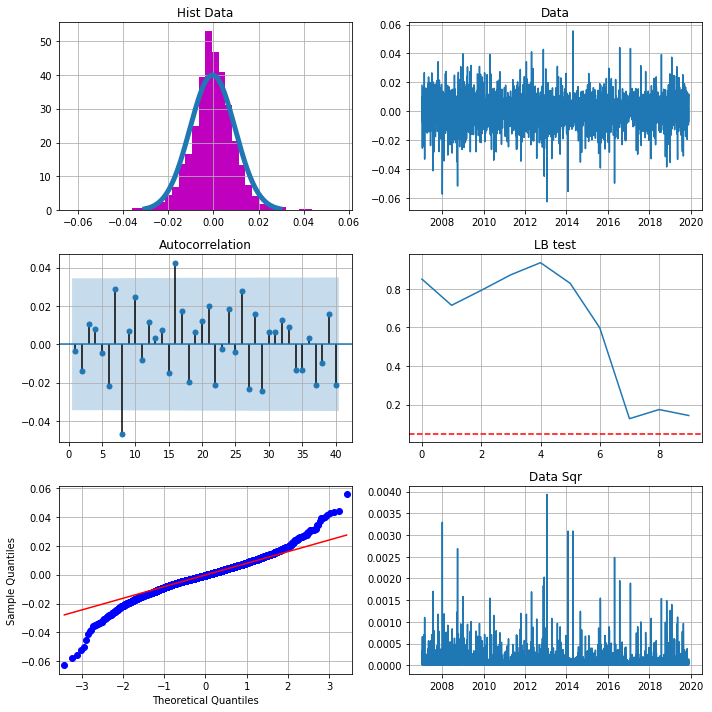

In [34]:
std_resid = res.resid/100/res.conditional_volatility
std_resid = std_resid.dropna()
plot_diagnosticsTight3(std_resid)

- The standardized residuals have passed the Ljung-Box test, supporting the case that they are white noise
- However, the QQ plot still does not seem to fit a normal, potentially a different distribution shoudl be considered.
- We should verify by formal normality tests: both reject hypothesis of normality.

In [68]:
JB_test = stats.jarque_bera(std_resid)
print('Jarque-Bera statitiscs: ', JB_test[0])
print('Jarque-Bera p-value: ', JB_test[1])

Jarque-Bera statitiscs:  1268.5349312012233
Jarque-Bera p-value:  0.0


In [69]:
shap_test = stats.shapiro(std_resid)
print('Shapiro statitiscs: ', shap_test[0])
print('Shapiro p-value: ', shap_test[1])

Shapiro statitiscs:  0.9698940515518188
Shapiro p-value:  1.4558832297067699e-25


8) Forecasting using the model

<img src="ARCHPic.png" width="1000">

Here the notatios follows the convention say for GARCH(1,1) with constant mean:

$$r_t = \mu + \epsilon_t$$
$$\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta\sigma^2_{t-1}$$
$$ \epsilon_t = \sigma_t e_t, \quad \ e_t \sim N(0,1)$$

In [70]:
forecasts = res.forecast(horizon=5)
print(forecasts.mean.iloc[-3:])

                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2019-11-22       NaN       NaN       NaN       NaN       NaN
2019-11-25       NaN       NaN       NaN       NaN       NaN
2019-11-26  0.123793  0.106276  0.261232  0.148816  0.176456


In [71]:
# To pick up the value of interest use -1
forecasts = res.forecast(horizon=5)
print(forecasts.mean.iloc[-1:])
print(forecasts.variance.iloc[-1:]) #Expected Variance of epsilon_t
print(forecasts.residual_variance.iloc[-1:])# Forecast variance of the process: Expected r**2_t

                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2019-11-26  0.123793  0.106276  0.261232  0.148816  0.176456
                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2019-11-26  2.165032  2.278891  2.431922  2.872997  2.874557
                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2019-11-26  2.165032  2.273564  2.426215  2.864397  2.862564


In [72]:
# Using simulation method
forecasts = res.forecast(horizon=5, method = 'simulation')
print(forecasts.mean.iloc[-1:])
print(forecasts.variance.iloc[-1:])
print(forecasts.residual_variance.iloc[-1:])

                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2019-11-26  0.123793  0.106276  0.261232  0.148816  0.176456
                 h.1       h.2       h.3      h.4       h.5
Date                                                       
2019-11-26  2.165032  2.271102  2.418944  2.85071  2.811137
                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2019-11-26  2.165032  2.265775  2.413257  2.842143  2.799209


Using Simulations in Forecast
===

In [73]:
# To illustrate example, set number of simulations to 6 and look at 3 step horizon:

forecasts = res.forecast(horizon=3, method = 'simulation',simulations = 6)  
print(forecasts.mean.iloc[-4:])
print(forecasts.variance.iloc[-4:])
print(forecasts.residual_variance.iloc[-4:])

#This will query expected values for the past 4 dates and display all horizons's expected values above.

                 h.1       h.2       h.3
Date                                    
2019-11-21       NaN       NaN       NaN
2019-11-22       NaN       NaN       NaN
2019-11-25       NaN       NaN       NaN
2019-11-26  0.123793  0.106276  0.261232
                 h.1       h.2       h.3
Date                                    
2019-11-21       NaN       NaN       NaN
2019-11-22       NaN       NaN       NaN
2019-11-25       NaN       NaN       NaN
2019-11-26  2.165032  2.160913  2.264497
                 h.1       h.2       h.3
Date                                    
2019-11-21       NaN       NaN       NaN
2019-11-22       NaN       NaN       NaN
2019-11-25       NaN       NaN       NaN
2019-11-26  2.165032  2.155586  2.259081


In [74]:
# What is the shape of this variable?
print(forecasts.simulations.values.shape)

# First dimension is 3248 which is the number of points used for fitting (last observation)
# Second dimension is the number of simulations
# Third dimenstion, the number of horizons (h-steps ahead)

# Notice that as we used all points in our fitting, the forecasts return NAN for all except the last point.
# Hence we will query only forecasts.simulations.values[-1,x,y] to extract only final date forecasts.

(3248, 6, 3)


In [75]:
# By printing all values is not necessarily intuitive to see what is going on
forecasts.simulations.values

array([[[        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan]],

       [[        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan]],

       [[        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan]],

       ...,

       [[        nan,         nan,         nan],
        [        nan,         nan,         nan],
 

In [76]:
# To get the value of LAST path, all 3 horizon simulations (h1,h2,h3):
forecasts.simulations.values[-1,-1,:] 

array([ 0.11172789, -2.023979  ,  0.39914064])

In [77]:
# To get the value of all simulations of h3 (only) 
forecasts.simulations.values[-1,:,-3] 
# 6 simulations for 3-step ahead horizon generated.

array([ 0.08001877, -0.05961194,  2.72989986, -0.29980017,  1.52517863,
        0.11172789])

In [78]:
# Change horizon to 5 and increase the number of simulations - this is exciting!
forecasts = res.forecast(horizon=5, method = 'simulation',simulations = 10)

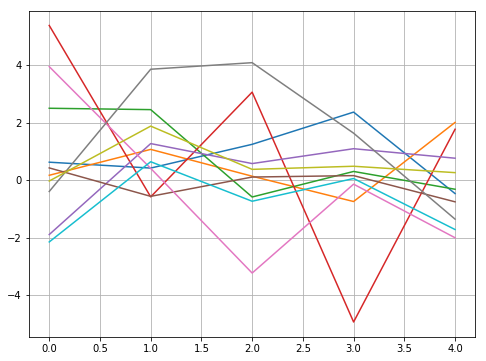

In [79]:
# To get ALL the paths, all 5 horizon simulations (h1..h5):
paths = forecasts.simulations.values[-1,:,:].T #Each path is a sequence of h1,h2,h3,h5 (and 10 paths displayed)
plt.plot(paths);
plt.grid()
plt.show()

In [80]:
# Why do I need to transpose?
forecasts.simulations.values[-1,:,:].shape 
# 10 by 5, I'm interested in the data as a 5 by 10 (5 points in the x axis for horizon, y is the value of each horizon path)

(10, 5)

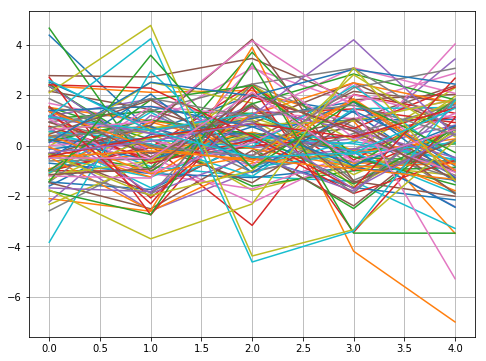

In [81]:
# Let's go crazy... 100 paths, what do we see now?
forecasts = res.forecast(horizon=5, method = 'simulation',simulations = 100)
paths = forecasts.simulations.values[-1,:,:].T 
#Each path is a sequence of h1,h2,h3,h5 (and 100 paths displayed)
plt.plot(paths);
plt.grid()
plt.show()

In [82]:
# To get a cross sample of all forecasts at a particular point in time, say all simulations of h-steps-ahead:
h1_values = forecasts.simulations.values[-1,:,0] 
h2_values = forecasts.simulations.values[-1,:,1] 
h3_values = forecasts.simulations.values[-1,:,2] 
h4_values = forecasts.simulations.values[-1,:,3] 
h5_values = forecasts.simulations.values[-1,:,4] 

In [83]:
# Hence, if I'm interested in the forecast of 5-day ahead, I can look at the distribution of the simulation
# to get confidence bounds around mean.
print(h5_values.mean())
print(h5_values.std())
# Find the quantiles
print(np.quantile(h5_values,0.025))
print(np.quantile(h5_values,0.975))

0.08819841358323796
1.802817042658234
-3.4756471656558205
2.9740348323429604


In [84]:
# Repeating for a more realistic number of simulations:
# Using simulation method
forecasts = res.forecast(horizon=5, method = 'simulation',simulations = 1000) 
h5_values = forecasts.simulations.values[-1,:,-1] 
h5_values.shape

(1000,)

0.1722653969861171
1.7155745731119059
-3.1853902419982973
3.5310891283892842


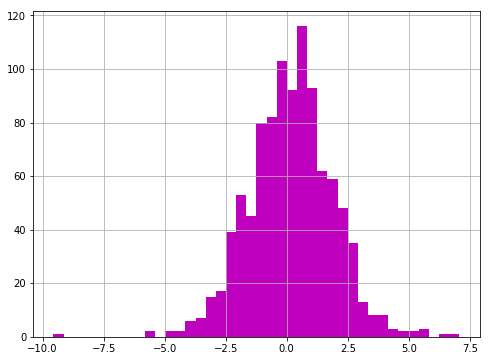

In [85]:
print(h5_values.mean())
print(h5_values.std())
# Find the quantiles
print(np.quantile(h5_values,0.025))
print(np.quantile(h5_values,0.975))
plt.hist(h5_values,bins = 40, color = 'm')
plt.grid()
plt.show()

In [86]:
# 30 day horizon, 1000 simulation points
numSim = 100
numH = 30
forecasts = res.forecast(horizon= numH, method = 'simulation',simulations = numSim) 
hLast_values = forecasts.simulations.values[-1,:,-1] 
hLast_values.shape

(100,)

In [87]:
######################################################################################
#
# Firstly I would like to find the mean of the forecast and the 95% conf interval
# For that, will pick up at the last observation (3149, the h1,...,h100 of each path)
# At every step, I can then get statistics across the paths at every step h1,...,h100 
#
######################################################################################

def plotHorizonForecast(data,tsData,getStats=False):
        #myData = sims.values
      
        numSims = data.shape[0]
        numH = data.shape[1]
          
        path = np.zeros(numSim)
        sizeNumH = numH + 1
        crossSlice = np.zeros((numH+1,numSims))

        mean = np.zeros(numH+1)
        Q95up = np.zeros(numH+1)  #0.975
        Q95down = np.zeros(numH+1) #0.275
        Q80up = np.zeros(numH+1)  #0.90
        Q80down = np.zeros(numH+1) #0.10

        # Add last obs as point 
        lastObsValue = tsData[tsData.index[-1]]
        
        for j in range(numSims): #for each path e  
            crossSlice[0][j] = lastObsValue 

        for j in range(numSims):
            for i in range(numH):
                crossSlice[i+1][j] = data[j][i]

        type(crossSlice)        
        for i in range(1,numH+1):
            mean[i] = stats.describe(crossSlice[i,:]).mean
            Q95up[i] = np.quantile(crossSlice[i,:],0.975)
            Q95down[i] = np.quantile(crossSlice[i,:],0.025)
            Q80up[i] = np.quantile(crossSlice[i,:],0.9)
            Q80down[i] = np.quantile(crossSlice[i,:],0.1)

                 
        plt.figure(1, figsize=(16,16))
        plt.plot(mean, color = 'm', alpha = 1)
        plt.plot(Q95up, color = 'r')
        plt.plot(Q95down, color = 'r')
        plt.plot(Q80up,color = 'g')
        plt.plot(Q80down,color = 'g')
        plt.grid()
        plt.show()
        if(getStats):
            myList = [mean,Q95up,Q95down,Q80up,Q80down]
            myNames= ['mean','Q95up','Q95down','Q80up','Q80down']
            myDict = dict(zip(myNames, myList))
            return myDict

In [88]:
sims = forecasts.simulations
sims.values[-1,:,:].shape
x = sims.values[-1,:,:]

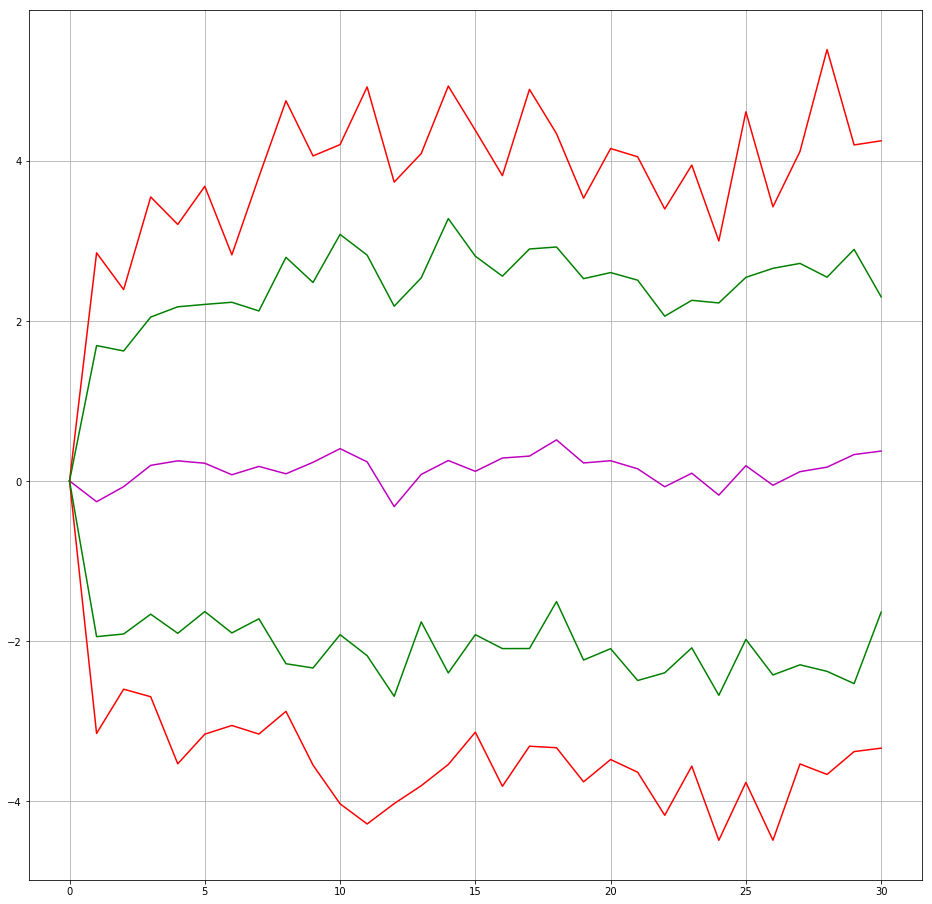

In [89]:
plotHorizonForecast(x,AAPLRet)

In order to be able to forecast with external regressors, we need split the original data for training  
===

- We can use original data and choose to fit the model up to a date, forecasting with the rest or
- We can extend the dataframe with a dummy for the "future dates" and give future values for external regressor

In [90]:
# We will use examples with simulation - for the purpose of this example, we will simply slice the 
# data as the "last_obs" to fit the model and all other points are ignored. Only the dates are 
# used for the future forecasting.
# Quickly figure out 100 days before last obs
AAPLRet.to_frame().shift(-20).tail(21)
#That is 2019-07-09: use this as last_obs as python won't include in the fitting of the model

,Adj Close
Date,
2019-10-29,-0.007839
2019-10-30,NaN
2019-10-31,NaN
2019-11-01,NaN
2019-11-04,NaN
2019-11-05,NaN
2019-11-06,NaN
2019-11-07,NaN
2019-11-08,NaN


In [91]:
split_date = '2019-10-30'
newAAPLRet = AAPLRet*100
arx = ARX(newAAPLRet, lags=4,rescale = False) #this is eq. to AR(4) as per above
arx.volatility = GARCH(5,0,0)
res = arx.fit(update_freq=0, last_obs = split_date)
print(res.summary())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6440.34999110935
            Iterations: 23
            Function evaluations: 330
            Gradient evaluations: 23
                           AR - ARCH Model Results                            
Dep. Variable:              Adj Close   R-squared:                      -0.003
Mean Model:                        AR   Adj. R-squared:                 -0.004
Vol Model:                       ARCH   Log-Likelihood:               -6440.35
Distribution:                  Normal   AIC:                           12902.7
Method:            Maximum Likelihood   BIC:                           12969.6
                                        No. Observations:                 3224
Date:                Thu, Nov 19 2020   Df Residuals:                     3213
Time:                        09:38:54   Df Model:                           11
                                   Mean Model                                  

In [92]:
numH = 100
forecasts = res.forecast(horizon=numH, method='simulation') #default number of simulations is 1000
sims = forecasts.simulations

In [93]:
sims.values.shape 
# 3228 number of past observations, plus 20 for forecast total of 3248
# Simulated 1000 paths
# Up to 20 days ahead
# Need to extract values of last 20days of paths for histogram

(3248, 1000, 100)

In [94]:
len(AAPLRet[:]) # up to last observation

3248

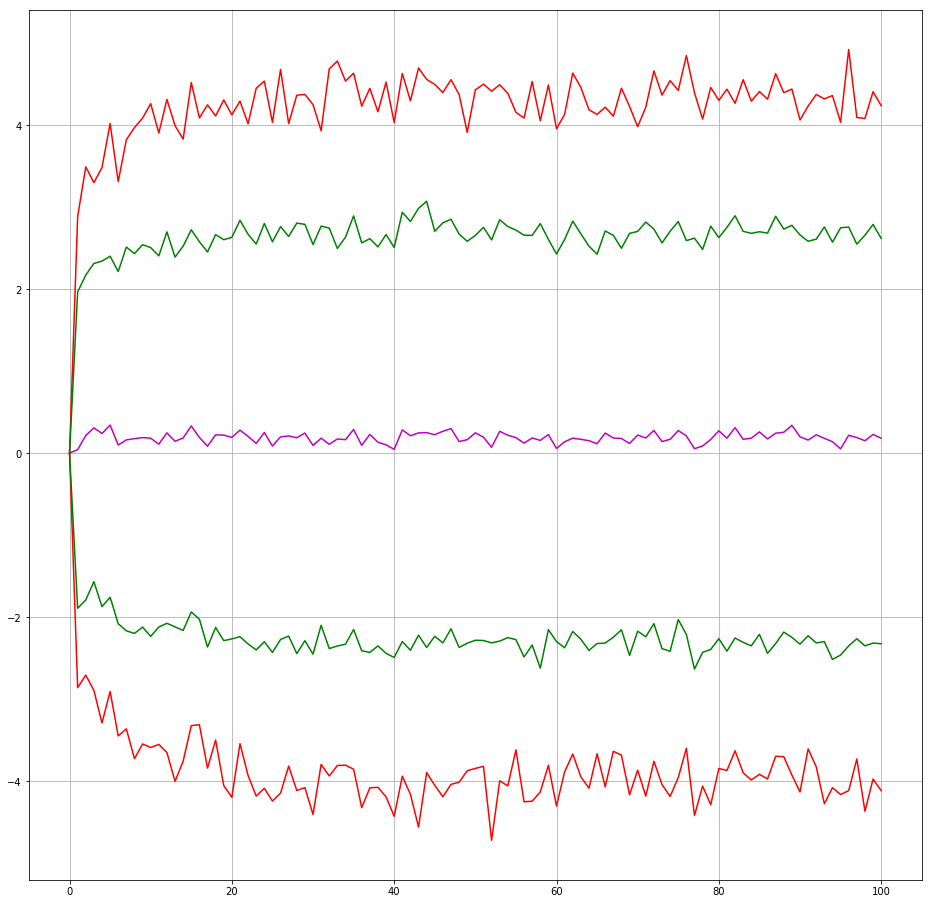

In [95]:
statsRtn = plotHorizonForecast(sims.values[-1,:,:],tsData=AAPLRet, getStats=True)

In [96]:
# Now we cannot have 100 days less
sims.values[-21,-1,0] 


1.0329660979839137

In [97]:
# Now we cannot have 100 days less
sims.values[-22,-1,0] 


nan

Most importantly:
===
We need to split the data in this way OR add dates up to the horizon we need to forecast
in original time series when we have

External Regressors
===

Whenever we have external regressors, in order to produce forecast, we need to provide the values
of the external forecast in future.

However, if we simply add this data as part of the external regressor but do not align the size
of the timeseries we are trying to fit, the model will not work:

Example to then forecast the actual price given the forecast of the returns
===

In [98]:
prices = AAPL['Adj Close']#AAPL[:'2019-10-29']['Adj Close']
lastPrice = prices[prices.index[-1]]
lastPrice 

64.97481536865234

Remeber that all returns are x by a factor of 100...so we need to divide by 100 to obtain correct units
===

In [99]:
def getPaths(data):
    numSim = data.shape[0]
    numH  = data.shape[1]
    totValueAcrossPath = np.zeros(numSim)
    for j in range(numSim): #for each path    
        for i in range(numH):
            totValueAcrossPath[j] =  totValueAcrossPath[j] + data[j][i]
        
    return totValueAcrossPath

In [100]:
print(sims.values[-1,:,:].shape)#100 day forecast
totReturnPaths = getPaths(sims.values[-1,:,:])
totReturnPaths.shape
# It contains the total path value 

(1000, 100)


(1000,)

totReturnPaths has added all the daily return for the forecast of 100 days ahead, path by path
===

In [101]:
# Now I can exponentite to get back original price
# But remember: you must scale back your returns if you have use this trick...
# And remember to use your initial spot the last spot observation

sizeN = len(totReturnPaths)
spotPrices = np.zeros(sizeN)
for i in range(sizeN):
    spotPrices[i] = np.exp(totReturnPaths[i]/100)*lastPrice


At last... we have the distribution of Spot 100 days ahead 
====

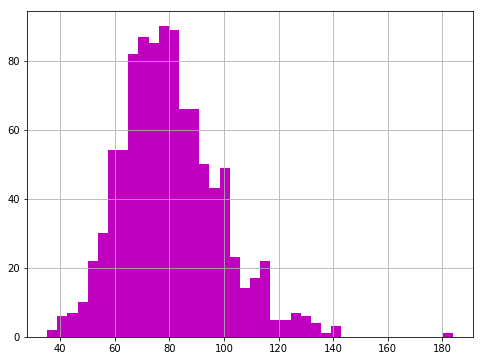

In [102]:
plt.hist(spotPrices, bins = 40, color = 'm')
plt.grid()
plt.show()

And hence we can calculate statistics on it...
===

In [103]:
mean = spotPrices.mean()
std = spotPrices.std()
Quant95up = np.quantile(spotPrices,0.975)
Quant95down = np.quantile(spotPrices,0.0275)
print('Mean: ', mean)
print('Std: ', std)
print('95% Q: ', Quant95up)
print('5% Q: ', Quant95down)

Mean:  80.41511817513685
Std:  18.100906206391425
95% Q:  122.00171636180906
5% Q:  50.805853707483024


How do we set the intervals?
===

- This is more tricky as we need to get the percentiles at every forecasting step h, to obtain the "path for 95%" forecast e.g.

In [104]:
def getPathsExp(forecastSims, lastPrice):
    numSim = forecastSims.shape[0]
    numH = forecastSims.shape[1]
    print(numSim)
    print(numH)
    totValueAcrossPath = np.zeros(numSim)
    spotData = np.zeros((numSim,numH+1))
    for j in range(numSim): #for each path    
        spotData[j,0]=lastPrice
        
    for j in range(numSim): #for each path    
        for i in range(numH):
            spotData[j][i+1] = np.exp(forecastSims[j][i]/100)*spotData[j][i]

    return spotData

In [105]:
print(lastPrice)
spotPaths = getPathsExp(sims.values[-1,:,:],lastPrice)

64.97481536865234
1000
100


In [106]:
spotPaths.T.shape

(101, 1000)

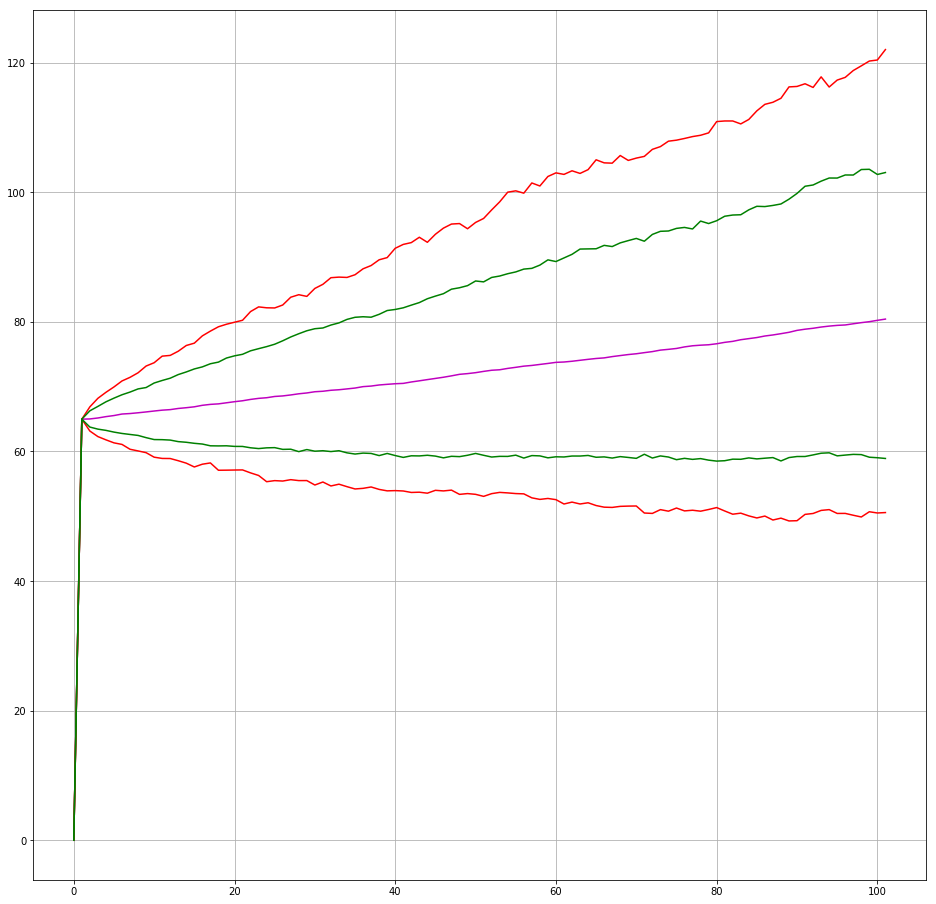

In [107]:
statsData = plotHorizonForecast(spotPaths[:,:],tsData=prices,getStats=True)
meanData = statsData['mean']

In [108]:
sims.values[-1,:,:].shape

(1000, 100)

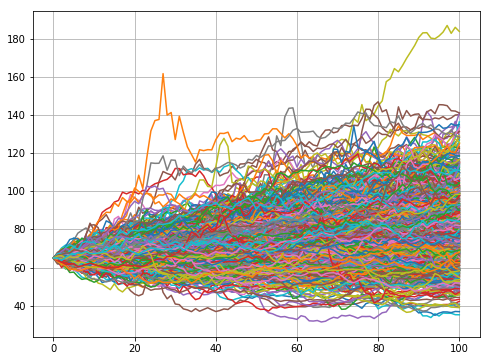

In [109]:
for k in range(1000):
    paths = spotPaths[k,:] 
    plt.plot(paths);

plt.grid()
plt.show()

In [110]:
# Generate new dates for the future...
keep = pd.bdate_range(start='2019-11-27', end='2020-04-14')
len(keep)

myList = [keep.values]
names = ['date']
myDict = dict(zip(names, myList))
df = pd.DataFrame({ key:pd.Series(value) for key, value in myDict.items()})
df.set_index(df['date'], inplace = True)
df.head()
del df['date']

In [111]:
AAPL[:]['Adj Close'].mean()

20.320146455732484

In [112]:
1.4242e-03*100

0.14242

In [113]:
lastPrice*np.exp(0.14242)

74.91991469407205

In [114]:
statsData['mean'][-1]

80.41511817513684

Considering External Regressors
===

In [115]:
start = dt.datetime(2007,1,1)
end = dt.datetime(2019,11,26)
SPY = web.get_data_yahoo('SPY', start=start, end=end)
SPYRet = np.log(SPY['Adj Close']).diff().dropna()
len(SPYRet)


3248

In [116]:
# One way to ensure that your date is aligned accross different time series is to 
# merge them as a dataframe
dates = SPYRet.index.values

myList = [dates,SPYRet.values,AAPLRet.values]
names = ['date','SPYRet','AAPLRet']
myDict = dict(zip(names, myList))
df = pd.DataFrame({ key:pd.Series(value) for key, value in myDict.items()})
df.set_index(df['date'], inplace = True)
del df['date']
df.tail()

,SPYRet,AAPLRet
date,,
2019-11-20,-0.003726,-0.011710
2019-11-21,-0.001610,-0.004494
2019-11-22,0.002221,-0.000878
2019-11-25,0.007720,0.017382
2019-11-26,0.002263,-0.007839


Need to re-consider models as now have a regressor...
===

                            OLS Regression Results                            
Dep. Variable:                AAPLRet   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     1928.
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        09:39:17   Log-Likelihood:                 8895.9
No. Observations:                3248   AIC:                        -1.779e+04
Df Residuals:                    3246   BIC:                        -1.778e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      2.451      0.0

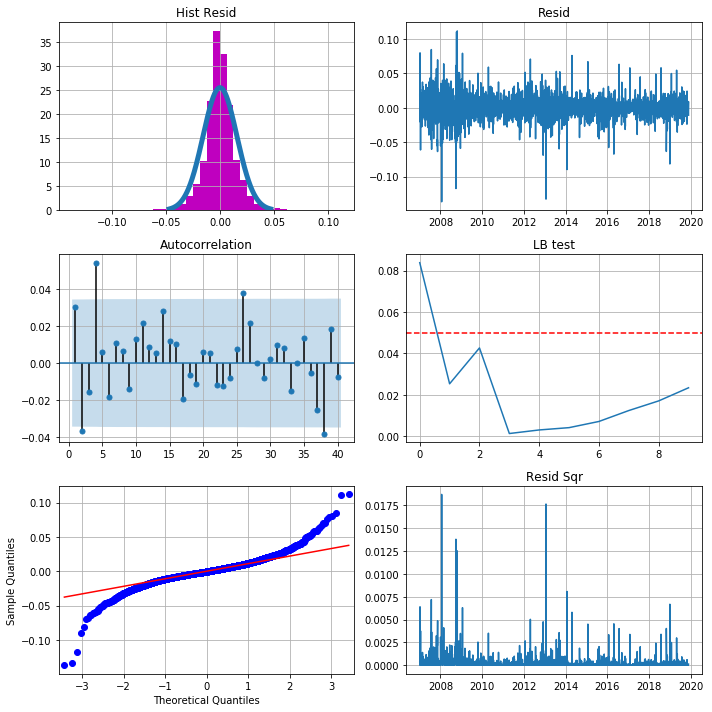

In [117]:
# Fit a linear regression

X1 = df[['SPYRet']]
X1 = sm.add_constant(X1)
y = df[['AAPLRet']]
model = sm.OLS(y, X1)
lm = model.fit()
print(lm.summary())
plot_diagnosticsTight3(data= lm.resid)

In [124]:
# reject unit root
test = adfuller(lm.resid, maxlag = 7)
print('ADF Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:i/')
for item, value in test[4].items():
    print('\t%s: %.2f' % (item, value))

ADF Statistic: -27.700031
p-value: 0.000000
Critical Values:i/
	1%: -3.43
	5%: -2.86
	10%: -2.57


In [125]:
# cannot reject stationarity 
m = int(np.log(len(lm.resid)))
test = kpss(lm.resid, lags=m) 
print('KPSS Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:')
for item, value in test[3].items():
    print('\t%s: %.2f' % (item, value))

KPSS Statistic: 0.257671
p-value: 0.100000
Critical Values:
	10%: 0.35
	5%: 0.46
	2.5%: 0.57
	1%: 0.74


In [126]:
# So let's find the order for the ARMA Model with Regression
X1 = df[['SPYRet']]
results = pm.auto_arima(df[['AAPLRet']],exogenous = X1, trace = True, d=0, seasonal=False, with_intercept=True ) #d = 1
# It likes (2,2) though we might need to go for (1,0) later given restriction in GARCH

Fit ARIMA: order=(2, 0, 2); AIC=-17796.165, BIC=-17753.565, Fit time=1.639 seconds
Fit ARIMA: order=(0, 0, 0); AIC=-17785.773, BIC=-17767.515, Fit time=0.009 seconds
Fit ARIMA: order=(1, 0, 0); AIC=-17786.764, BIC=-17762.421, Fit time=0.069 seconds
Fit ARIMA: order=(0, 0, 1); AIC=-17787.000, BIC=-17762.657, Fit time=0.030 seconds
Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 0, 2); AIC=-17795.177, BIC=-17746.490, Fit time=1.375 seconds
Fit ARIMA: order=(2, 0, 1); AIC=-17787.506, BIC=-17750.991, Fit time=0.288 seconds
Fit ARIMA: order=(2, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 4.032 seconds


In [127]:
print(results.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3248
Model:                     ARMA(2, 2)   Log Likelihood                8905.083
Method:                       css-mle   S.D. of innovations              0.016
Date:                Thu, 19 Nov 2020   AIC                         -17796.165
Time:                        09:40:09   BIC                         -17753.565
Sample:                             0   HQIC                        -17780.904
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      2.437      0.015       0.000       0.001
x1             0.9865      0.022     44.083      0.000       0.943       1.030
ar.L1.y       -0.4363      0.163     -2.673      0.0

In [128]:
searchARMA(df[['AAPLRet']],X1,max_p = 5, max_q = 5)

p: 0  q: 0  aic: -17781.765233185986
p: 0  q: 1  aic: -17783.3635990118
p: 0  q: 2  aic: -17784.682788152255
p: 0  q: 3  aic: -17783.672144390024
p: 0  q: 4  aic: -17791.35811369296
p: 1  q: 0  aic: -17783.113301222467
p: 2  q: 0  aic: -17785.2778410668
p: 2  q: 1  aic: -17783.38635138185
p: 2  q: 2  aic: -17792.23803791509
p: 3  q: 0  aic: -17783.724196102066
p: 3  q: 1  aic: -17784.67340984772
p: 3  q: 2  aic: -17791.064007457448
p: 4  q: 0  aic: -17791.939029994002
p: 4  q: 1  aic: -17789.96628725613
p: 4  q: 2  aic: -17789.525890861125
p: 4  q: 3  aic: -17790.790612448258
p: 4  q: 4  aic: -17787.118065965613


In [129]:
# Notice optimal choice is ARMA(2,2), but ARCH model does not work with ARMA!
# Choosing ARMA(4,0) is not bad as AIC very close, second choice and it will work with ARCH

model = ARIMA(df[['AAPLRet']], exog = X1, order=(4,0,0))
results = model.fit()
print(results.summary());

                              ARMA Model Results                              
Dep. Variable:                AAPLRet   No. Observations:                 3248
Model:                     ARMA(4, 0)   Log Likelihood                8904.778
Method:                       css-mle   S.D. of innovations              0.016
Date:                Thu, 19 Nov 2020   AIC                         -17795.556
Time:                        09:40:42   BIC                         -17752.956
Sample:                             0   HQIC                        -17780.295
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0007      0.000      2.379      0.017       0.000       0.001
SPYRet            0.9855      0.022     43.993      0.000       0.942       1.029
ar.L1.AAPLRet     0.0319      0.018     

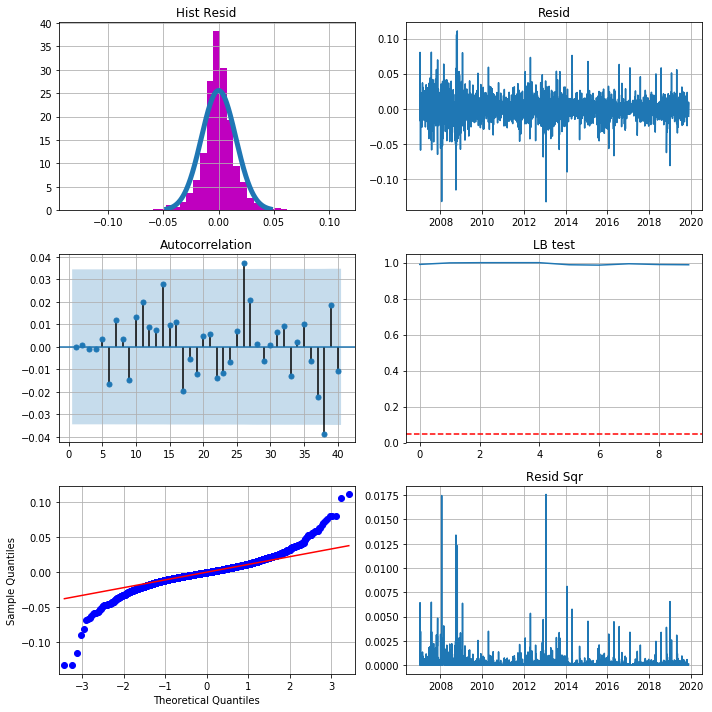

In [131]:
plot_diagnosticsTight3(results.resid)

In [132]:
# reject unit root
test = adfuller(results.resid, maxlag = 7)
print('ADF Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:i/')
for item, value in test[4].items():
    print('\t%s: %.2f' % (item, value))

ADF Statistic: -56.985859
p-value: 0.000000
Critical Values:i/
	1%: -3.43
	5%: -2.86
	10%: -2.57


In [133]:
# cannot reject stationarity 
m = int(np.log(len(results.resid)))
test = kpss(results.resid, lags=m) 
print('KPSS Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:')
for item, value in test[3].items():
    print('\t%s: %.2f' % (item, value))

KPSS Statistic: 0.249336
p-value: 0.100000
Critical Values:
	10%: 0.35
	5%: 0.46
	2.5%: 0.57
	1%: 0.74


In [134]:
resid2 = results.resid**2
searchARMA(resid2,exog, max_p = 3, max_q = 3)

p: 0  q: 1  aic: -37063.27157914059
p: 0  q: 2  aic: -37113.52084193194
p: 1  q: 0  aic: -37092.323351344814
p: 1  q: 1  aic: -37431.346921004595
p: 1  q: 2  aic: -37430.974643995876
p: 2  q: 0  aic: -37161.2313343799
p: 2  q: 1  aic: -37430.9934349368
p: 2  q: 2  aic: -37429.894183796074


In [135]:
# Let's estimate the resid2 ARMA
resid2 = results.resid**2
results = pm.auto_arima(resid2,trace = True, d=0, seasonal=False, with_intercept=False) #d = 1

# Looks like (1,1)

Fit ARIMA: order=(2, 0, 2); AIC=-37429.894, BIC=-37399.465, Fit time=0.622 seconds
Fit ARIMA: order=(0, 0, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0); AIC=-37092.323, BIC=-37080.152, Fit time=0.011 seconds
Fit ARIMA: order=(0, 0, 1); AIC=-37063.272, BIC=-37051.100, Fit time=0.015 seconds
Fit ARIMA: order=(1, 0, 2); AIC=-37430.975, BIC=-37406.631, Fit time=0.381 seconds
Fit ARIMA: order=(1, 0, 1); AIC=-37431.347, BIC=-37413.090, Fit time=0.300 seconds
Fit ARIMA: order=(2, 0, 1); AIC=-37430.993, BIC=-37406.650, Fit time=0.384 seconds
Total fit time: 1.714 seconds


In [136]:
# Scaling the external regressor does not make a difference as it embeds the scaling in the coeff.
X1 = df[['SPYRet']]
newAAPL = df[['AAPLRet']]*100
arx = ARX(newAAPL, x = X1, lags=4,  constant = True, rescale = False) #this is eq. to AR(4) as per above
arx.volatility = GARCH(1,0,1)
res2 = arx.fit(update_freq=0, tol=0.00001,last_obs = split_date)
print(res2.summary())


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5720.165618977007
            Iterations: 18
            Function evaluations: 226
            Gradient evaluations: 18
                          AR-X - GARCH Model Results                          
Dep. Variable:                AAPLRet   R-squared:                       0.375
Mean Model:                      AR-X   Adj. R-squared:                  0.374
Vol Model:                      GARCH   Log-Likelihood:               -5720.17
Distribution:                  Normal   AIC:                           11458.3
Method:            Maximum Likelihood   BIC:                           11513.0
                                        No. Observations:                 3224
Date:                Thu, Nov 19 2020   Df Residuals:                     3215
Time:                        09:44:56   Df Model:                            9
                                  Mean Model                                  

In [137]:
numH = 100
forecasts2 = res2.forecast(horizon=numH, method='simulation',simulations = 1000) #default number of simulations is 1000
sims2 = forecasts2.simulations

In [138]:
sims2.values.shape

(3248, 1000, 100)

In [139]:
sims2.values[-1,10,:]

array([-0.5476707 , -0.02508403,  2.41166417, -0.29975102,  1.58915063,
        0.28366118,  3.15867293,  2.26025973,  0.10847798, -0.31152092,
       -0.7355259 , -0.26822389,  1.42676527,  1.08873396,  0.82069369,
       -1.47295237, -0.20082386,  1.16050633,  0.97042473,  0.38303918,
        1.06762312,  0.19047943,  0.95944953,  0.1073168 , -0.43917079,
       -1.08010894, -1.09799157, -0.35561615, -0.04067342,  0.63033631,
       -0.96736048,  0.25948491, -2.39289824, -1.14612356, -0.26265752,
        2.56583286,  0.18426074,  0.54869174,  1.19085299, -0.10972561,
       -1.58758073,  0.1724187 , -1.22998916, -0.6893715 ,  3.30271006,
        2.19468899, -0.68132105, -2.55800155, -2.68874315, -6.02026193,
       -0.09464487,  2.48344873,  0.66350018,  1.21317024,  1.9431777 ,
        1.52814983, -1.55303856,  0.56556031, -1.58692927,  0.17002174,
       -0.06637285,  1.88670584,  2.49875552, -3.54025058,  2.08762617,
        0.22107563, -0.07553105,  1.00860609,  0.95480914, -0.49

In [140]:
spotPaths2 = getPathsExp(sims2.values[-1,:,:],lastPrice)
spotPaths2.shape

1000
100


(1000, 101)

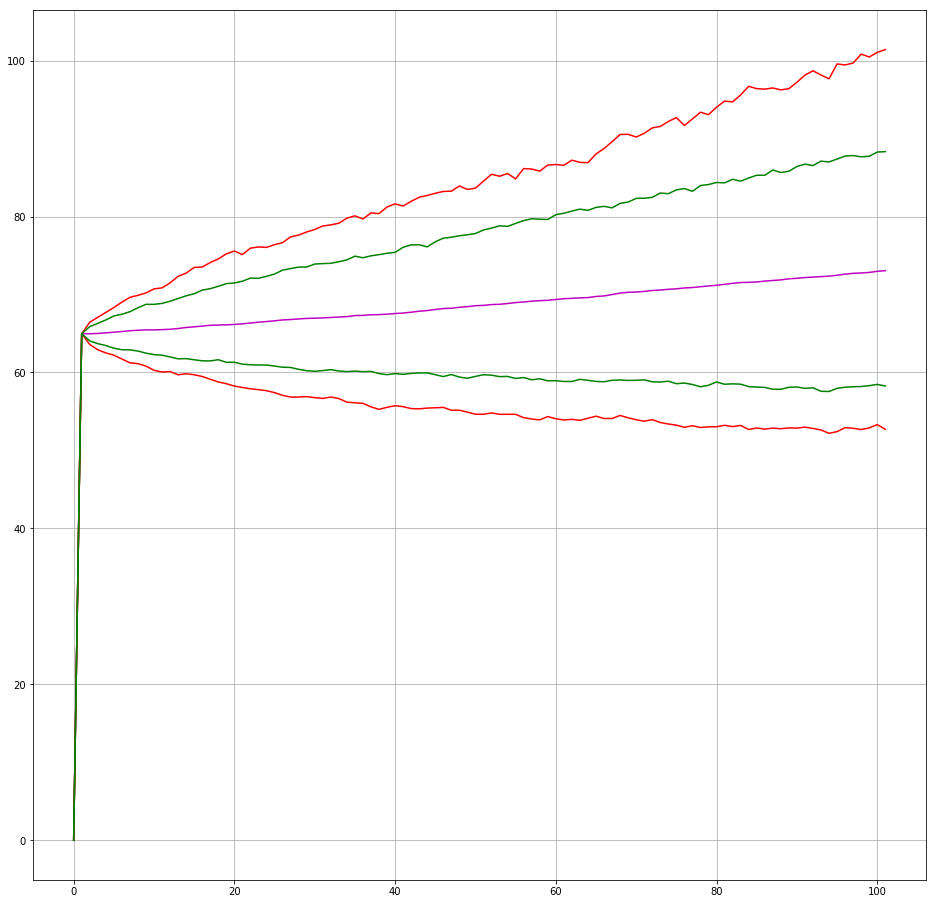

In [141]:
statsData2 = plotHorizonForecast(spotPaths2,tsData=prices,getStats=True)
meanData2 = statsData2['mean']

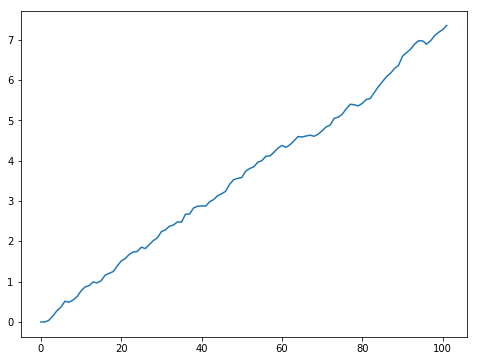

In [142]:
plt.plot(meanData-meanData2) #Now it works... it takes into acc regression

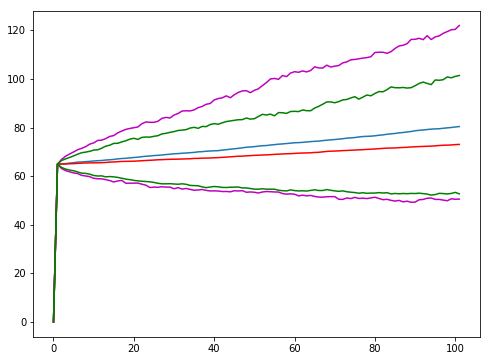

In [143]:
plt.plot(meanData)
plt.plot(statsData['Q95down'], color= 'm')
plt.plot(statsData['Q95up'], color= 'm')
plt.plot(meanData2, color= 'red')
plt.plot(statsData2['Q95down'], color= 'green')
plt.plot(statsData2['Q95up'], color= 'green')

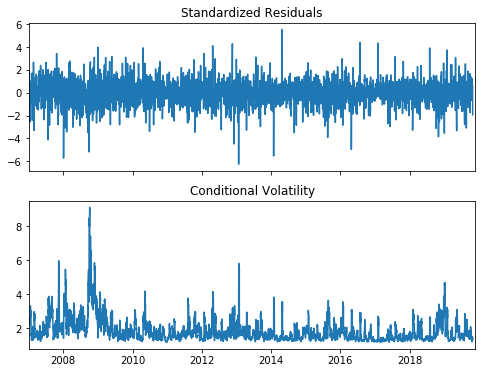

In [144]:
res.plot();

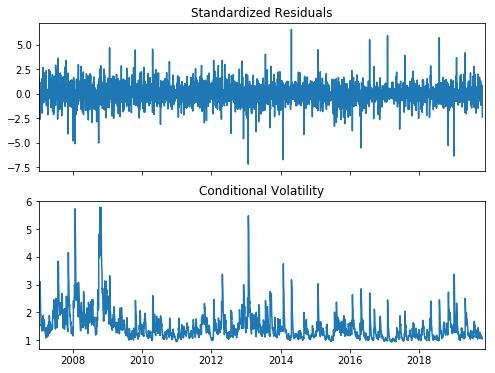

In [145]:
res2.plot();

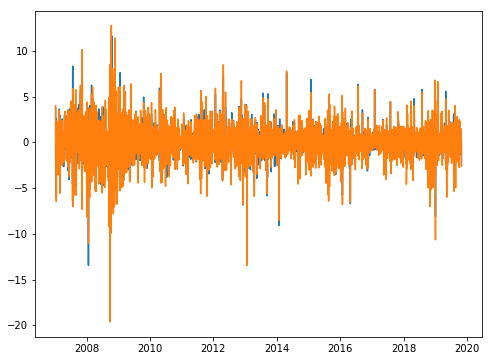

In [146]:
plt.plot(res2.resid.dropna())
plt.plot(res.resid.dropna())

In [147]:
std1 = res2.resid.dropna().std()
std1

1.561080572269138

In [148]:
std2 = res.resid.dropna().std()
std2

1.9770692283405915

In [149]:
np.exp((std2-std1))*300

454.7606018601369

In [150]:
resid2 = res2.resid.dropna()
resid = res.resid.dropna()

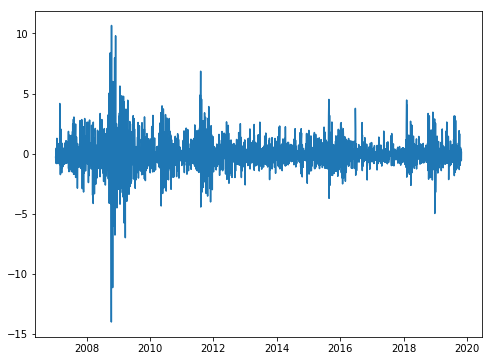

In [151]:
plt.plot(resid2-resid)

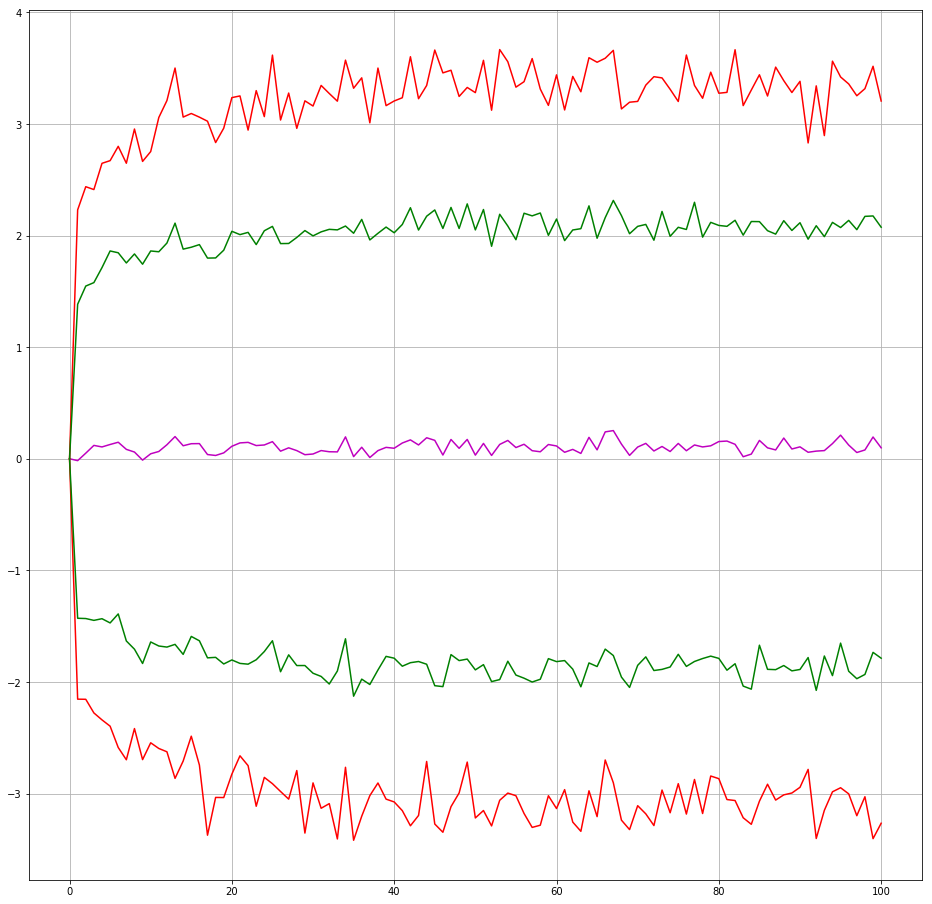

In [152]:
statsRtn2 = plotHorizonForecast(sims2.values[-1,:,:],tsData=AAPLRet, getStats=True)

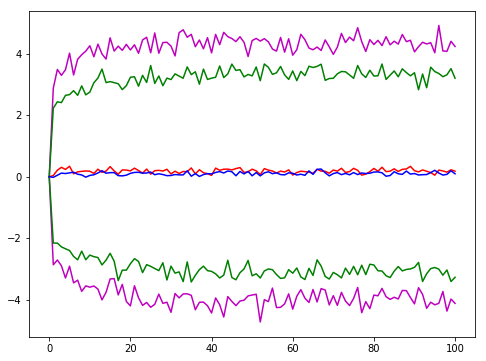

In [153]:
plt.plot(statsRtn['Q95down'], color= 'm')
plt.plot(statsRtn['Q95up'], color= 'm')
plt.plot(statsRtn['mean'], color= 'red')
plt.plot(statsRtn2['Q95down'], color= 'green')
plt.plot(statsRtn2['Q95up'], color= 'green')
plt.plot(statsRtn2['mean'], color= 'blue')

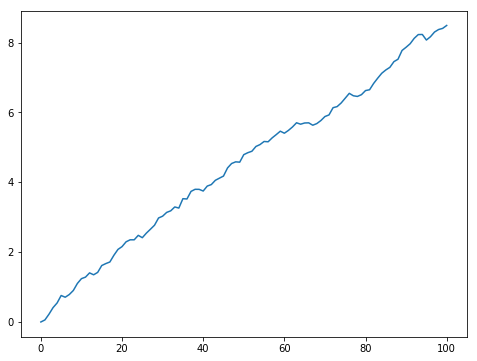

In [154]:
plt.plot(np.cumsum(statsRtn['mean'] - statsRtn2['mean']))

Diagnostics for model with regression
===

In [157]:
std_resid2 = res2.resid/100/res2.conditional_volatility
std_resid2 = std_resid2.dropna()

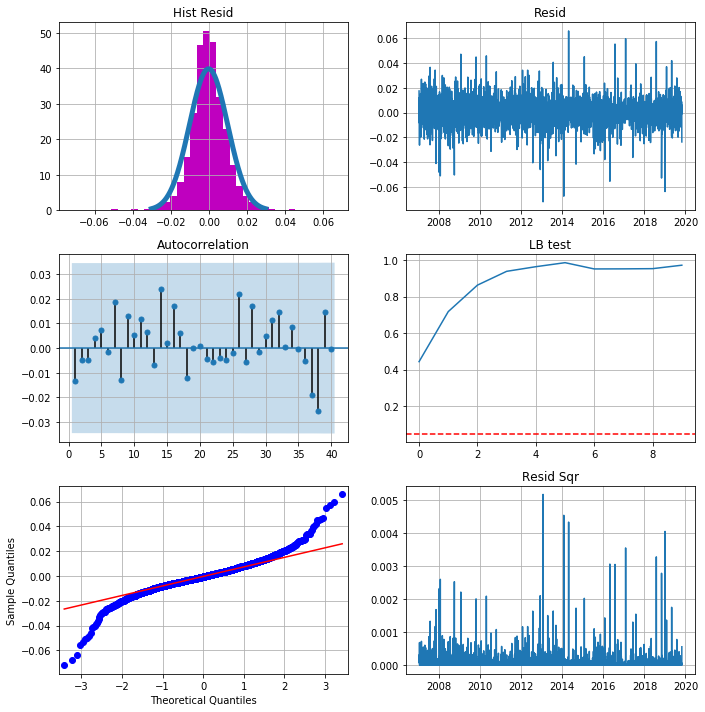

In [158]:
plot_diagnosticsTight3(std_resid2)

- It also passes the LB test, but as expected, no change to QQ plot - it will most likely fail the Shapiro and JB tets
- We can try next to fit other distributions.

<Figure size 576x360 with 0 Axes>

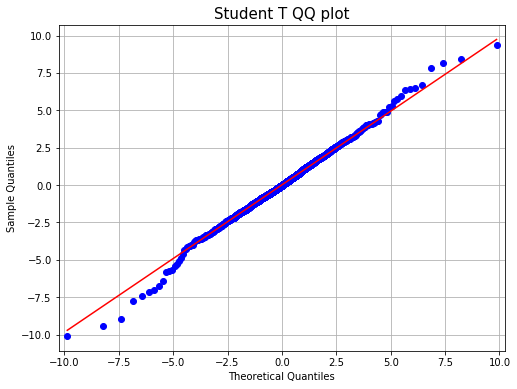

In [160]:
plt.figure(1, figsize=(8,5))
fig = sm.qqplot(std_resid2, stats.t, fit = True,line='q')
plt.title('Student T QQ plot', fontsize=15)
plt.grid()

In [161]:
# Scaling the external regressor does not make a difference as it embeds the scaling in the coeff.
from arch.univariate import StudentsT

X1 = df[['SPYRet']]
newAAPL = df[['AAPLRet']]*100
arx = ARX(newAAPL, x = X1, lags=4,  constant = True, rescale = False) #this is eq. to AR(4) as per above
arx.volatility = GARCH(1,0,1)
arx.distribution = StudentsT()
res3 = arx.fit(update_freq=0, tol=0.00001,last_obs = split_date)
print(res3.summary())



Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5456.938777197863
            Iterations: 21
            Function evaluations: 280
            Gradient evaluations: 21
                             AR-X - GARCH Model Results                             
Dep. Variable:                      AAPLRet   R-squared:                       0.376
Mean Model:                            AR-X   Adj. R-squared:                  0.375
Vol Model:                            GARCH   Log-Likelihood:               -5456.94
Distribution:      Standardized Student's t   AIC:                           10933.9
Method:                  Maximum Likelihood   BIC:                           10994.7
                                              No. Observations:                 3224
Date:                      Thu, Nov 19 2020   Df Residuals:                     3214
Time:                              09:54:16   Df Model:                           10
                        

In [162]:
std_resid3 = res3.resid/100/res3.conditional_volatility
std_resid3 = std_resid3.dropna()

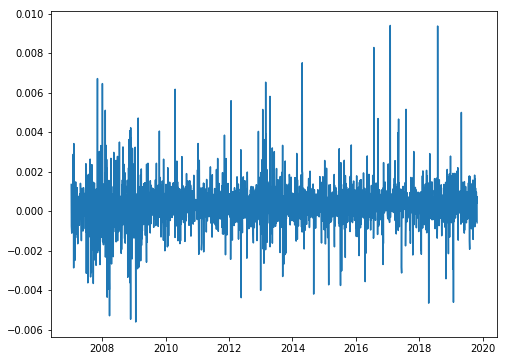

In [163]:
plt.plot(std_resid3 - std_resid2)

In [164]:
std_resid3.std()

0.009976541671438788

In [165]:
std_resid2.std()

0.010002179203247035

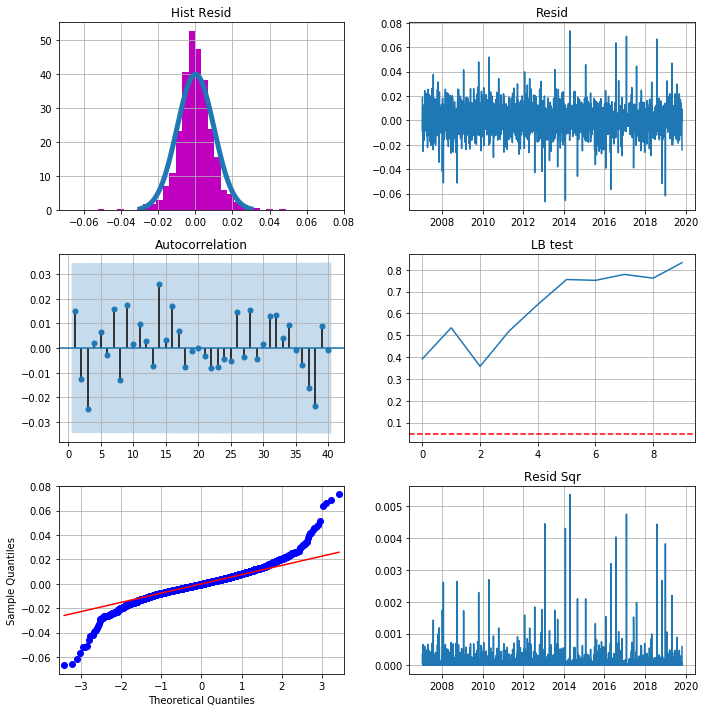

In [166]:
plot_diagnosticsTight3(std_resid3)

<Figure size 1080x864 with 0 Axes>

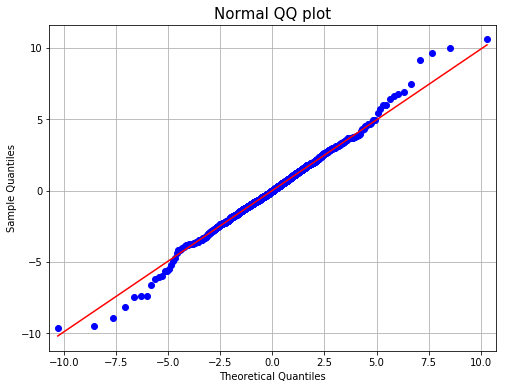

In [168]:
plt.figure(1, figsize=(15,12))
fig = sm.qqplot(std_resid3, stats.t, fit = True,line='q')
plt.title('Normal QQ plot', fontsize=15)
plt.grid()

In [169]:
# Scaling the external regressor does not make a difference as it embeds the scaling in the coeff.
from arch.univariate import SkewStudent

X1 = df[['SPYRet']]
newAAPL = df[['AAPLRet']]*100
arx = ARX(newAAPL, x = X1, lags=4,  constant = True, rescale = False) #this is eq. to AR(4) as per above
arx.volatility = GARCH(1,0,1)
arx.distribution = SkewStudent()
res4 = arx.fit(update_freq=0, tol=0.00001,last_obs = split_date)
print(res4.summary())


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5454.077884277194
            Iterations: 22
            Function evaluations: 315
            Gradient evaluations: 22
                                AR-X - GARCH Model Results                               
Dep. Variable:                           AAPLRet   R-squared:                       0.376
Mean Model:                                 AR-X   Adj. R-squared:                  0.375
Vol Model:                                 GARCH   Log-Likelihood:               -5454.08
Distribution:      Standardized Skew Student's t   AIC:                           10930.2
Method:                       Maximum Likelihood   BIC:                           10997.0
                                                   No. Observations:                 3224
Date:                           Thu, Nov 19 2020   Df Residuals:                     3213
Time:                                   09:56:32   Df Model:         

In [171]:
std_resid4 = res4.resid/100/res4.conditional_volatility
std_resid4 = std_resid4.dropna()

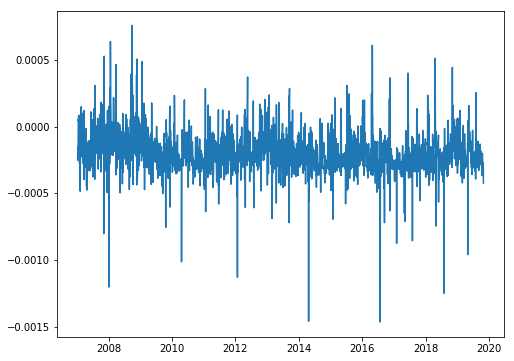

In [172]:
plt.plot(std_resid4 - std_resid3)

In [173]:
std_resid4.std()

0.009938430245492864

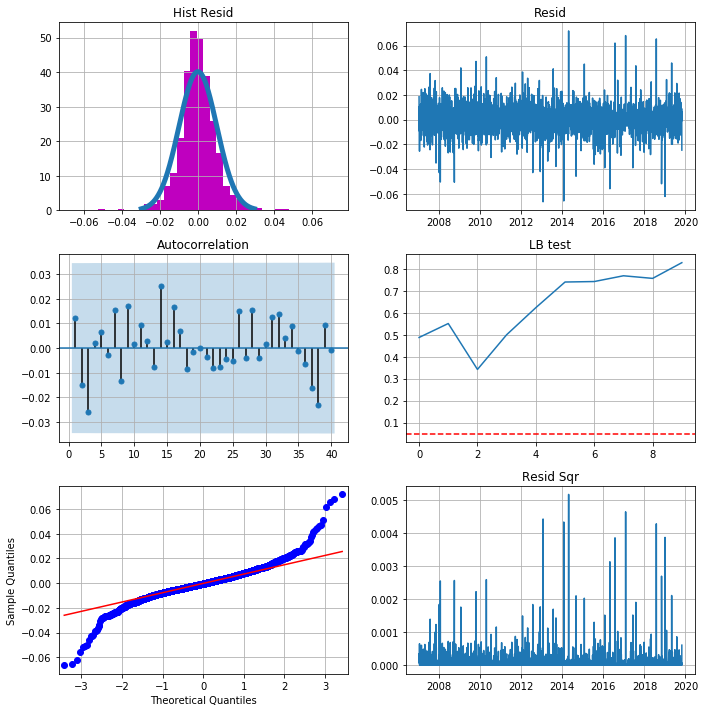

In [175]:
plot_diagnosticsTight3(std_resid4)

<Figure size 1080x864 with 0 Axes>

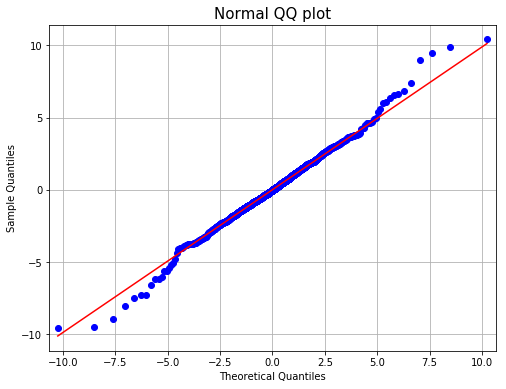

In [176]:
plt.figure(1, figsize=(15,12))
fig = sm.qqplot(std_resid4, stats.t, fit = True,line='q')
plt.title('Normal QQ plot', fontsize=15)
plt.grid()